In [184]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
import scipy.spatial.distance

In [185]:
def loadData(filename='input.data'):
    data = np.loadtxt(filename)
    return data[:, 0, None], data[:, 1, None]

In [186]:
def computeK(Xn, Xm, sigma, l, alpha):
    # compute the K matrix between vectors of Xn and vectors of Xm
    # Xn, Xm: both in shape (N, k), k is the dimension of data, N is the number of data
    # sigma: the overall variance (amplitude)
    # l: lengthscale
    # alpha: scale-mixture
    
    def computeSingleKernel(xn, xm):
        # xn, xm: vector
        # k(xn, xm) = sigma ^ 2 * (1 + (xn - xm) ^ 2 / (2 * alpha * l ^ 2)) ^ -alpha
        return sigma ** 2 * (1 + np.linalg.norm(xn - xm, ord=1) ** 2 / (2 * alpha * l ** 2)) ** -alpha
    
    N = Xn.shape[0]
    M = Xm.shape[0]
    K = np.empty((N, M))
    
    for n in range(N):
        for m in range(M):
            K[n, m] = computeSingleKernel(Xn[n], Xm[m])
    
    return K

def computeC(X, sigma, l, alpha, beta):
    # compute covariance C of f(x)
    # X: in shape (N, k)
    return computeK(X, X, sigma, l, alpha) + np.eye(X.shape[0]) / beta

In [187]:
def computePredictiveDistribution(X_test, X_train, Y_train, sigma, l, alpha, beta):
    C = computeC(X_train, sigma, l, alpha, beta)
    k = computeK(X_train, X_test, sigma, l, alpha)
    
    k_star = np.diag(computeC(X_test, sigma, l, alpha, beta)).reshape(-1, 1)
    
    C_inv = np.linalg.inv(C)
    
    mu = k.T @ C_inv @ Y_train
    # var = k_star - k.T @ C_inv @ k # (then find diag, but much slower)
    var = k_star - np.sum((k.T @ C_inv) * k.T, axis=1, keepdims=True)
    
    return mu, var

In [188]:
def optimize(loss: callable, X_train, Y_train, beta):
    return scipy.optimize.minimize(lossFunction, np.ones(3), args=(X_train, Y_train, beta), method='CG').x

def lossFunction(param, X_train, Y_train, beta):
    # MLE on p(y | theta)
    # negative log-likelihood
    # param: ndarray([sigma, l, alpha])
    
    C = computeC(X_train, *param, beta)
    C_inv = np.linalg.inv(C)
    
    return (X_train.shape[0] * np.log(2 * np.pi) + np.log(np.linalg.det(C)) + (Y_train.T @ C_inv @ Y_train).item()) / 2

# Experiments

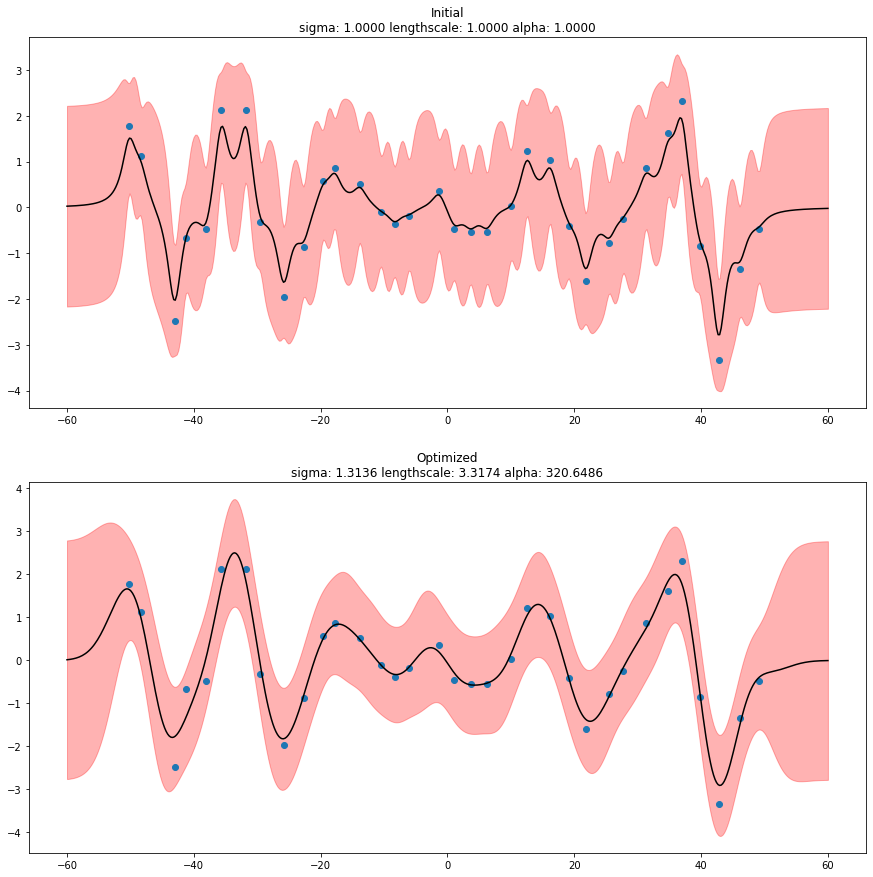

In [189]:
X_train, Y_train = loadData()
beta = 5.

plt.figure(figsize=(15, 15))

# param: ndarray([sigma, l, alpha])
param = np.array([1., 1., 1.]) # initial param

X_test = np.linspace(-60, 60, num=500).reshape(-1, 1)

# predictive distribution
mu, var = computePredictiveDistribution(X_test, X_train, Y_train, *param, beta=beta)

# plot
plt.subplot(2, 1, 1)
plt.title('Initial\nsigma: {:.4f} lengthscale: {:.4f} alpha: {:.4f}'.format(*param))
plt.plot(X_train, Y_train, 'o')
plt.plot(X_test, mu, 'k')
plt.fill_between(X_test.reshape(-1), (mu - 2 * var ** 0.5).reshape(-1), (mu + 2 * var ** 0.5).reshape(-1), color='red', alpha=0.3)
# plt.ylim(-4, 4)



# optimal param
param = optimize(lossFunction, X_train, Y_train, beta=beta)

# predictive distribution
mu, var = computePredictiveDistribution(X_test, X_train, Y_train, *param, beta=beta)

# plot
plt.subplot(2, 1, 2)
plt.title('Optimized\nsigma: {:.4f} lengthscale: {:.4f} alpha: {:.4f}'.format(*param))
plt.plot(X_train, Y_train, 'o')
plt.plot(X_test, mu, 'k')
plt.fill_between(X_test.reshape(-1), (mu - 2 * var ** 0.5).reshape(-1), (mu + 2 * var ** 0.5).reshape(-1), color='red', alpha=0.3)

# plt.savefig('fig.png')
plt.show()